### Exploratory Data Analysis (EDA)

### Target (output) variable: <br>
__Total number of users__ (guests-users + registered-users) <br>


### Predictor (input) variables: 
1. __Date__ - YYYY/MM/DD
2. __Hour__ - 0 to 23
3. __Weather__ - Description of weather conditions that hour
4. __Temperature__ - Average temperature for that hour (Fahrenheit)
5. __Feels-Like-Temperature__ - Average feeling temperature for that hour (Fahrenheit)
6. __Relative Humidity__ - Average relative humidity for that hour. Measure of the amount of water in the air (%).
7. __Windspeed__ - Average wind speed that hour
8. __PSI__ - Pollutant standard index. Measure of pollutants present in the air. (0 to 400).

In [1]:
#Import customed developed functions from mlp folder
from mlp.main import data_ingest, process_data, feature_engineering, \
feature_engineering2, reorder_columns, train_fit_evaluate, split_data_to_train_test

# Ignore  the warnings
import warnings
warnings.filterwarnings('always')
warnings.filterwarnings('ignore')

#Data visualisation and manipulation
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import style
import seaborn as sns
import missingno as msno

#Configure
#Sets matplotlib to inline and displays graphs below the corressponding cell.
%matplotlib inline  

#Import the necessary modelling algorithms

#Regression
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor,BaggingRegressor,AdaBoostRegressor
from sklearn.svm import SVR 

#Model selection
from sklearn.model_selection import train_test_split

#Evaluation metrics
from sklearn.metrics import mean_squared_log_error,mean_squared_error, r2_score,mean_absolute_error # for regression
from sklearn.metrics import accuracy_score,precision_score,recall_score,f1_score  # for classification

#Machine Learning Pipelines
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

In [2]:
link = '/Users/user/barry_yap/data'
df = data_ingest(link)
df.head()

,date,hr,weather,temperature,feels-like-temperature,relative-humidity,windspeed,psi,guest-users,registered-users
0,2011-01-01,0,clear,66.7,95.0,81.0,0.0,3,21,164
1,2011-01-01,1,clear,65.0,93.2,80.0,0.0,35,54,417
2,2011-01-01,2,clear,65.0,93.2,80.0,0.0,38,35,356
3,2011-01-01,3,clear,66.7,95.0,75.0,0.0,35,19,129
4,2011-01-01,4,clear,66.7,95.0,75.0,0.0,11,-2,10


In [3]:
df.shape

(17958, 10)

In [4]:
df.columns

Index(['date', 'hr', 'weather', 'temperature', 'feels-like-temperature',
       'relative-humidity', 'windspeed', 'psi', 'guest-users',
       'registered-users'],
      dtype='object')

In [5]:
df.dtypes

date                       object
hr                          int64
weather                    object
temperature               float64
feels-like-temperature    float64
relative-humidity         float64
windspeed                 float64
psi                         int64
guest-users                 int64
registered-users            int64
dtype: object

In [6]:
#Describe function for numerical attributes
df.describe()

,hr,temperature,feels-like-temperature,relative-humidity,windspeed,psi,guest-users,registered-users
count,17958.000000,17958.000000,17958.000000,17958.000000,17958.000000,17958.000000,17958.000000,17958.000000
mean,11.533578,88.457512,117.332008,62.758993,12.733155,24.557300,249.740394,1998.910346
std,6.915319,16.285017,20.416251,19.266532,8.213750,14.451091,344.815252,1966.561546
min,0.000000,48.100000,60.800000,0.000000,0.000000,0.000000,-2.000000,-5.000000
25%,6.000000,75.200000,100.400000,48.000000,7.000000,12.000000,27.000000,441.000000
50%,12.000000,88.700000,118.400000,63.000000,13.000000,24.000000,117.000000,1504.000000
75%,18.000000,102.200000,134.600000,78.000000,17.000000,37.000000,338.000000,2860.000000
max,23.000000,131.000000,179.600000,100.000000,57.000000,49.000000,2567.000000,11519.000000


From above, we noticed that:

* 'Temperature' and 'feels-like-temperature' column have units of measurement in degrees Fahrenheit.  <br>

* Max PSI is 49, which corresponds to healthy range of PSI. We know from this that we are not dealing with weather conditions with high air pollution. E.g haze or smog. <br>

* 'Guest-users' and 'registered-users' column has negative values. There might be a mistake when filling up the guest-users and registered-users column as it cannot be that number of users is negative. We shall replace all negative values with 0 instead.  <br>

* There is no missing values in the dataset as count for all columns is 17958 (equal to the number of rows of the dataset).  <br>



In [7]:
#Describe function for non-numerical attributes
non_num_index = df.dtypes[df.dtypes == 'object'].index
print(df[non_num_index].describe())
print(' ')
print(df['date'].value_counts())
print(' ')
print(df['weather'].value_counts())

              date weather
count        17958   17958
unique         731       9
top     2011-10-01   clear
freq            30   11186
 
2011-10-01    30
2012-07-30    28
2011-04-15    28
2012-12-01    27
2011-06-04    27
              ..
2011-01-26    16
2011-01-18    12
2012-10-30    11
2011-01-27     8
2012-10-29     1
Name: date, Length: 731, dtype: int64
 
clear              11186
cloudy              4492
light snow/rain     1429
lear                 323
CLEAR                288
loudy                111
CLOUDY                95
LIGHT SNOW/RAIN       31
heavy snow/rain        3
Name: weather, dtype: int64


From above, we noticed that:
* Most frequently occuring value would be __Oct 11, 2011__. This should not be the case as each date should only appear a maximum 24 times - corresponding to 24 hours (2011-10-01, Hr: 0 to 2011-10-01, Hr: 23). Having Oct 11 appearing __30 times__ would mean that there are duplicated entries. We need to remove the duplicated entries

In [8]:
#Missing values - below implies no null values hence no imputation required
df.isnull().sum()

date                      0
hr                        0
weather                   0
temperature               0
feels-like-temperature    0
relative-humidity         0
windspeed                 0
psi                       0
guest-users               0
registered-users          0
dtype: int64

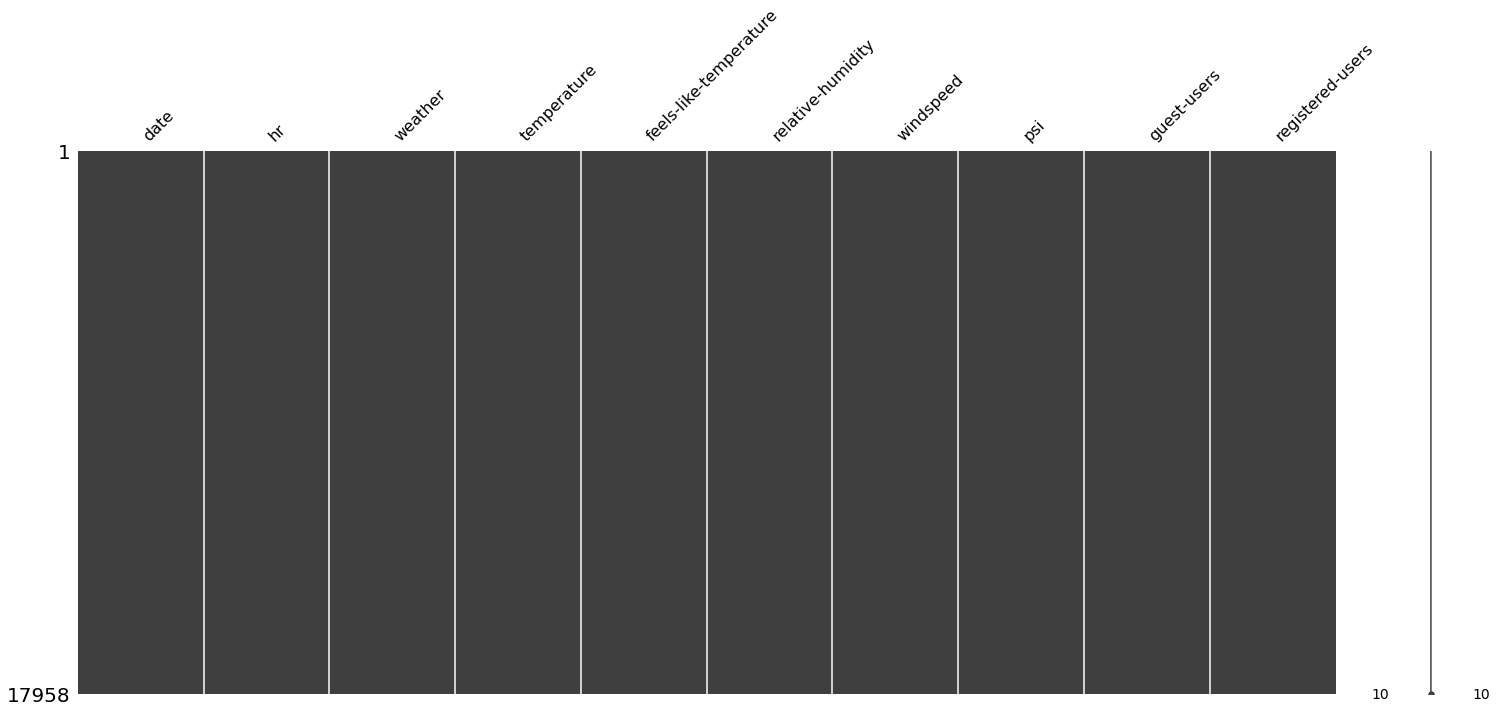

In [9]:
#Visualising missing values to double confirm
msno.matrix(df)

### Data manipulation so we can visualise better

We run the process_data function from mlp to:

    
1) Remove all duplicate rows in the dataframe <br>
2) Change 'weather' values to lowercase to prevent extra unique values. <br>
       Correct/remove typo errors/duplicated values in the 'weather' column. <br>
       Namely: <br>
       __'clear'__ and __'lear'__ -> missing a letter c <br>
       __'cloudy'__ and __'loudy'__ -> missing a letter c <br>
       __'light snow/rain'__ and __'LIGHT SNOW/RAIN'__ -> the latter value is an uppercase representation of the same value <br>

    We will do some manipulation to the data to replace the missing letters and convert all values in the weather column to lowercase.

3) Convert negative user values to 0 and prints out the unique values. <br>


In [10]:
df = process_data(df)
df.head()

['clear' 'cloudy' 'light snow/rain' 'loudy' 'lear' 'heavy snow/rain']
['clear' 'cloudy' 'light snow/rain' 'heavy snow/rain']
[False]
[False]


,date,hr,weather,temperature,feels-like-temperature,relative-humidity,windspeed,psi,guest-users,registered-users
0,2011-01-01,0,clear,66.7,95.0,81.0,0.0,3,21,164
1,2011-01-01,1,clear,65.0,93.2,80.0,0.0,35,54,417
2,2011-01-01,2,clear,65.0,93.2,80.0,0.0,38,35,356
3,2011-01-01,3,clear,66.7,95.0,75.0,0.0,35,19,129
4,2011-01-01,4,clear,66.7,95.0,75.0,0.0,11,0,10


We can tell from below that the data collected for this dataset spans a period of 2 years (Jan 2011 to Dec 2012).

In [11]:
print(min(df.date))
print(max(df.date))

2011-01-01
2012-12-31


We then run the feature_engineering function to:<br>
1) Create the attribute 'total-users' from 'guest-users' and 'registered-users' attributes.<br>
2) It also creates 'year', 'month' and 'weekday_name' from 'date' attribute.<br>
3) This function returns the dataframe with all the newly created variables in it.<br>

In [12]:
df = feature_engineering(df)

In [13]:
df.head()

,date,hr,weather,temperature,feels-like-temperature,relative-humidity,windspeed,psi,guest-users,registered-users,total-users,year,month,weekday_name
0,2011-01-01,0,clear,66.7,95.0,81.0,0.0,3,21,164,185,2011,1,Saturday
1,2011-01-01,1,clear,65.0,93.2,80.0,0.0,35,54,417,471,2011,1,Saturday
2,2011-01-01,2,clear,65.0,93.2,80.0,0.0,38,35,356,391,2011,1,Saturday
3,2011-01-01,3,clear,66.7,95.0,75.0,0.0,35,19,129,148,2011,1,Saturday
4,2011-01-01,4,clear,66.7,95.0,75.0,0.0,11,0,10,10,2011,1,Saturday


### Visualisation of attributes

Univariate analysis (Histogram)

We visualise the histogram plots to check the distribution of the feature and independent attributes

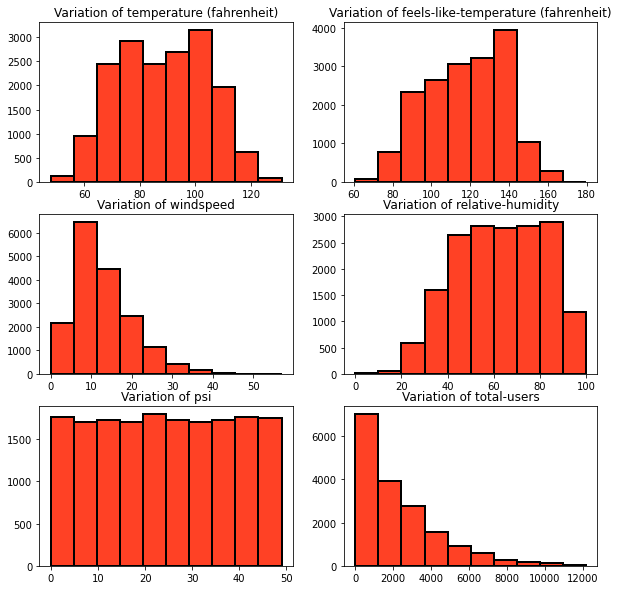

In [14]:
fig,axes=plt.subplots(3,2)
axes[0,0].hist(x="temperature",data=df,edgecolor="black",linewidth=2,color='#ff4125')
axes[0,0].set_title("Variation of temperature (fahrenheit)")
axes[0,1].hist(x="feels-like-temperature",data=df,edgecolor="black",linewidth=2,color='#ff4125')
axes[0,1].set_title("Variation of feels-like-temperature (fahrenheit)")
axes[1,0].hist(x="windspeed",data=df,edgecolor="black",linewidth=2,color='#ff4125')
axes[1,0].set_title("Variation of windspeed")
axes[1,1].hist(x="relative-humidity",data=df,edgecolor="black",linewidth=2,color='#ff4125')
axes[1,1].set_title("Variation of relative-humidity")
axes[2,0].hist(x="psi",data=df,edgecolor="black",linewidth=2,color='#ff4125')
axes[2,0].set_title("Variation of psi")
axes[2,1].hist(x="total-users",data=df,edgecolor="black",linewidth=2,color='#ff4125')
axes[2,1].set_title("Variation of total-users")

fig.set_size_inches(10,10)

It turns out that total-users is skewed to the left. We can consider doing a log transformation on it.

Bi-variate analysis (Scatterplot, Boxplot and Pearson Correlation)

2.0


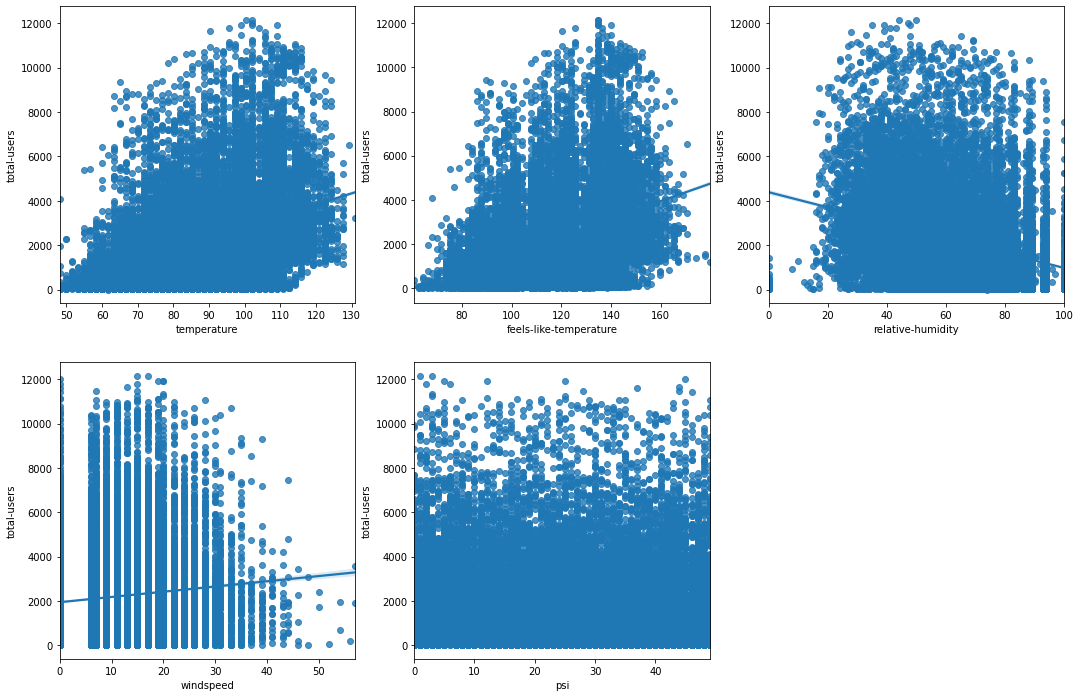

In [15]:
#Scatter Plot of numerical attributes
num_var = ['temperature','feels-like-temperature', 'relative-humidity','windspeed','psi','total-users']
categ_var = ['date','month','weekday_name','hr','weather']

fig, ax = plt.subplots(round(len(num_var) / 3), 3, figsize = (18, 12))
print(len(num_var) / 3)
#fig.delaxes(axes[0][1])
ax[1,2].remove()

for i, ax in enumerate(fig.axes):
    if i < len(num_var) - 1:
        sns.regplot(x=num_var[i],y='total-users', data=df[num_var], ax=ax)


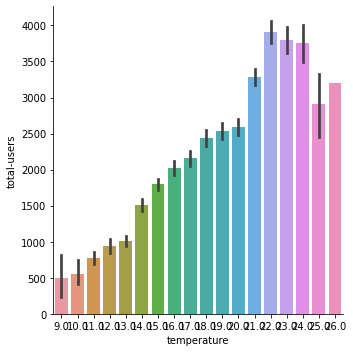

In [16]:
new_df=df.copy()
new_df.temperature.describe()
new_df['temperature']=np.floor(new_df['temperature'])//5
new_df['temperature'].unique()
# now we can visualize as follows
sns.catplot(x="temperature",y="total-users",data=new_df,kind='bar')

For temperature values, it is easier to visualise when it is split into different bins.<br>
From here, we can see that the total users increase along with temperature.<br>
This could be because it is too hot to be walking, hence they switched to cycling. <Br>

(array([0, 1, 2, 3]), <a list of 4 Text major ticklabel objects>)

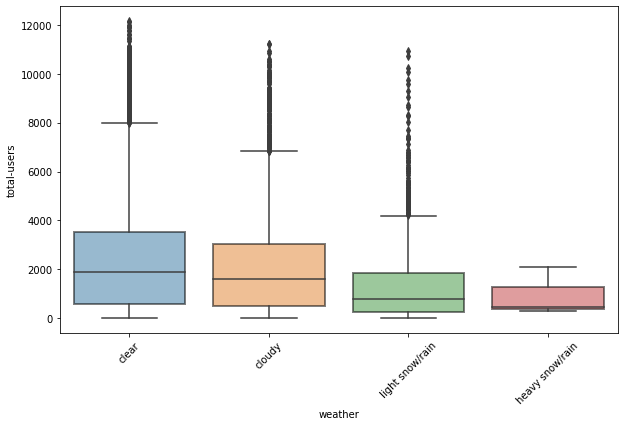

In [17]:
#Boxplot of categorical attributes

#total-users vs weather
plt.figure(figsize = (10, 6))
ax = sns.boxplot(x='weather', y=df['total-users'], data= df)
plt.setp(ax.artists, alpha=.5, linewidth=2, edgecolor="k")
plt.xticks(rotation=45)


We observe from above that the total number of users increase when the weather is clear.
This is expected as people would be less likely to go outdoors in heavy snow/train unless they really do not have a choice.

(array([0, 1]), <a list of 2 Text major ticklabel objects>)

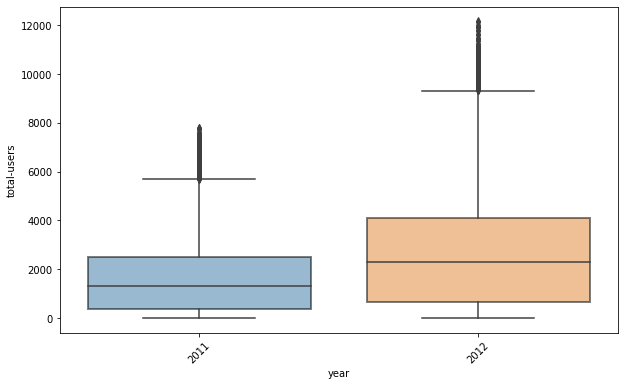

In [18]:

#total-users vs year 
plt.figure(figsize = (10, 6))
ax = sns.boxplot(x='year', y=df['total-users'], data= df)
plt.setp(ax.artists, alpha=.5, linewidth=2, edgecolor="k")
plt.xticks(rotation=45)


From the graph above, we can see that number of users also increased in 2012. This may cause substantial error if we were to use this data to predict demand for recent years (2019-2020). It would not account for the year on year increase that could happen.

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11]),
 <a list of 12 Text major ticklabel objects>)

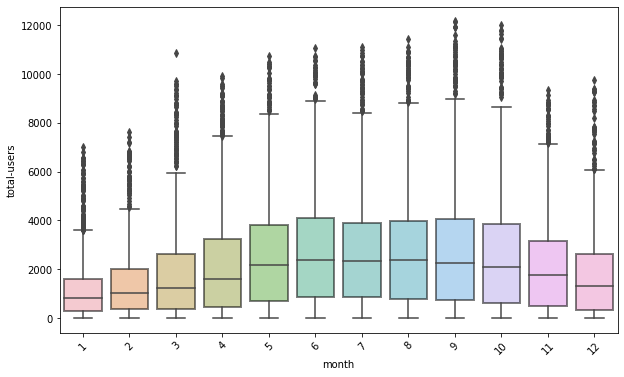

In [19]:

#total-users vs month
plt.figure(figsize = (10, 6))
ax = sns.boxplot(x='month', y=df['total-users'], data= df)
plt.setp(ax.artists, alpha=.5, linewidth=2, edgecolor="k")
plt.xticks(rotation=45)



From above, there is a lull period for rentals near the end and start of the year. This could probably coincide with likely holiday period.

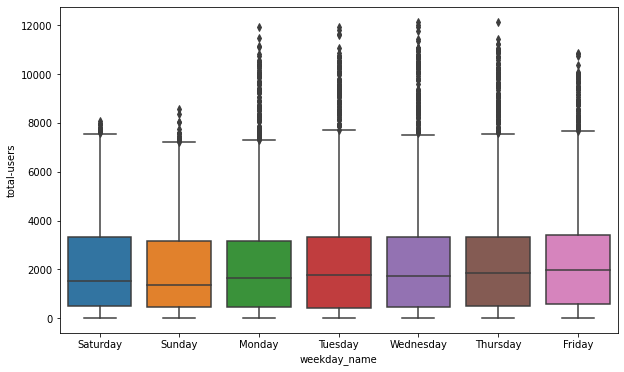

In [20]:
#total-user vs weekday_name
plt.figure(figsize = (10, 6))
sns.boxplot(data=df, x='weekday_name', y='total-users');
#sns.swarmplot(data=df, x='weekday_name', y='total-users')



From the box plot above, we can see that there are lesser users renting the bikes on Saturday and Sunday compared to the weekdays. The natural outliers are also significantly lesser.

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23]),
 <a list of 24 Text major ticklabel objects>)

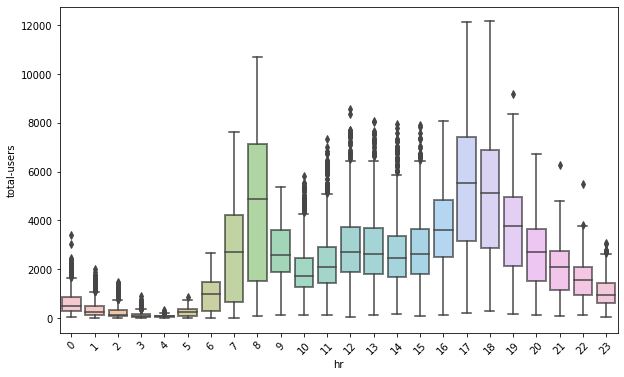

In [21]:
#total-users vs hr
plt.figure(figsize = (10, 6))
ax = sns.boxplot(x='hr', y=df['total-users'], data= df)
plt.setp(ax.artists, alpha=.5, linewidth=2, edgecolor="k")
plt.xticks(rotation=45)

From the chart above, we can tell that there are 2 obvious peaks. One at 8am and the other at about 5pm.
These probably corresponds to the time people go to and come back from work. These are the peak hours for bicycle rental.
Whereas we can also notice that rentals are very low from 10pm to 4am where people are typically resting at home.

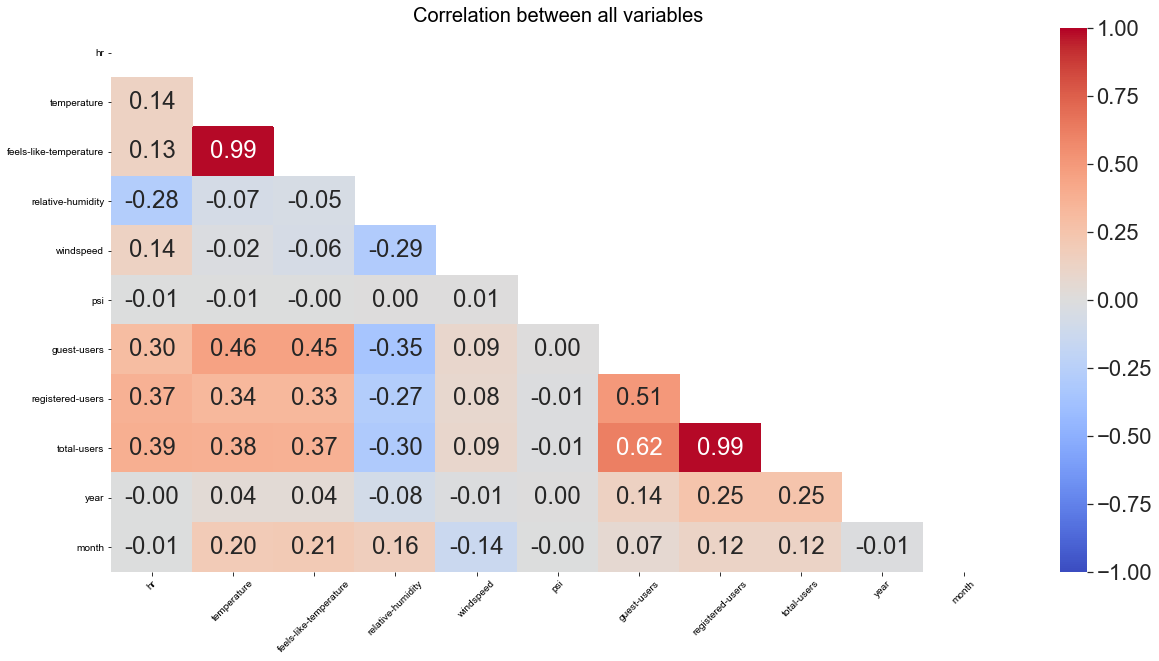

In [22]:
#Pearson Correlation

plt.figure(figsize = (20,10))
plt.title('Correlation between all variables', fontsize = 20);
 
# Mask to remove redundancy from the heatmap.
sns.set(font_scale=2)
mask = np.zeros_like(df.corr())
mask[np.triu_indices_from(mask)] = True
 
sns.heatmap(df.corr(), mask = mask,vmin=-1, vmax = 1, cmap = "coolwarm",  annot = True, fmt=".2f")
plt.xticks(rotation=45)
plt.show()


## Elaborate more on below the reasons

The correlation map above gives us a clear picture of the pearson correlation between variables. <br>

As expected, there are a few very highly correlated pairs (pearson correlation >0.9): <br>
* temperature and feels-like-temperature - feels-like-temperature is afterall temperature + certain environment factors
* total users and registered users - total users is afterall the sum of registered and guest users

As well as moderately correlated pairs (pearson correlation 0.5 to 0.7) : <br>
* guest-users and registered-users - <br>
guest users and registered users might have rented the bike for different reasons hence the reason for only moderate correlation. Registered users might need it regularly (e.g for work) while guests would probably rent them for leisure purpose.
* guest-users and total-users - same reason as above hence not highly correlated.

Low correlation (pearson correlation 0.25 to 0.5) : <br>
* guest-users/registered-users/total-users and temperature
* guest-users/registered-users/total-users and feels-like-temperature
* relative-humidity and windspeed (low negative correlation) 
* relative-humidity and guest-users/registered-users/total-users (low negative correlation)- as the air becomes more humid, people tend to avoid going out/ exercising hence the negative correlation.



### Feature Engineering

We then apply feature engineering to the variables with the function feature_engineering2: <br>
1) This function converts all categorical values ('weather' and 'weekday_name') into numerical values instead. <br>
 * if catgorical variables do not get transformed to numerical variables, it is likely to affect the accuracy of the model
    
2) It then drops all unnecessary columns that are required for testing the model.<br>
3) Finally, it returns a dataframe that is cleaned and ready to feed into machine
    learning models for testing.<br>

We also apply the reorder_columns function to the dataframe so that all time values are on the left while all temperature/numerical values are on the right.

In [23]:
df2 = feature_engineering2(df)
df2 = reorder_columns(df2)

In [24]:
df2.head()

,year,month,hr,Monday,Tuesday,Wednesday,Thursday,Friday,Saturday,Sunday,clear,cloudy,light snow/rain,heavy snow/rain,temperature,feels-like-temperature,relative-humidity,windspeed,psi,total-users
0,2011,1,0,0,0,0,0,0,1,0,1,0,0,0,66.7,95.0,81.0,0.0,3,185
1,2011,1,1,0,0,0,0,0,1,0,1,0,0,0,65.0,93.2,80.0,0.0,35,471
2,2011,1,2,0,0,0,0,0,1,0,1,0,0,0,65.0,93.2,80.0,0.0,38,391
3,2011,1,3,0,0,0,0,0,1,0,1,0,0,0,66.7,95.0,75.0,0.0,35,148
4,2011,1,4,0,0,0,0,0,1,0,1,0,0,0,66.7,95.0,75.0,0.0,11,10


We split the data into test set and training set to feed into the machine learning models.

In [25]:
x_train,x_test,y_train,y_test = split_data_to_train_test(df2)

In [26]:
x_test.head()

,year,month,hr,Monday,Tuesday,Wednesday,Thursday,Friday,Saturday,Sunday,clear,cloudy,light snow/rain,heavy snow/rain,temperature,feels-like-temperature,relative-humidity,windspeed,psi
5943,2011,9,4,0,0,0,0,0,1,0,1,0,0,0,95.5,125.6,94.0,6.0,1
15739,2012,10,0,0,1,0,0,0,0,0,1,0,0,0,85.3,114.8,88.0,11.0,3
2906,2011,5,0,0,0,0,0,1,0,0,1,0,0,0,83.6,113.0,44.0,11.0,6
12842,2012,6,7,0,0,0,0,0,0,1,1,0,0,0,100.5,132.8,69.0,7.0,3
9053,2012,1,3,0,0,1,0,0,0,0,0,1,0,0,83.6,113.0,51.0,33.0,7


## Model Testing

With the train_fit_evaluate function below, we: <Br>
1) Do feature scaling on the variables
2) Fit the machine learning models using pipelines
3) Evaluate the accuracy of the machine learning model.


In [27]:
train_fit_evaluate(x_train,x_test,y_train,y_test)

[Pipeline] ............... (step 1 of 2) Processing scl, total=   0.0s
[Pipeline] ............... (step 2 of 2) Processing rfr, total=   5.0s
[Pipeline] ............... (step 1 of 2) Processing scl, total=   0.0s
[Pipeline] ............... (step 2 of 2) Processing abr, total=   0.7s
[Pipeline] ............... (step 1 of 2) Processing scl, total=   0.0s
[Pipeline] ................ (step 2 of 2) Processing br, total=   0.6s
[Pipeline] ............... (step 1 of 2) Processing scl, total=   0.0s
[Pipeline] ............... (step 2 of 2) Processing svr, total=  10.5s
[Pipeline] ............... (step 1 of 2) Processing scl, total=   0.0s
[Pipeline] ................ (step 2 of 2) Processing lr, total=   0.0s
Random Forest Regressor Test Accuracy: 0.9138611483725718
Ada Boost Regressor Test Accuracy: 0.6111643394407253
Bagging Regressor Test Accuracy: 0.9049591972123376
SVR Test Accuracy: 0.03388304703678946
Linear Regression Test Accuracy: 0.35676772330590123
Classifier with best accuracy:Rand

From above, we conclude that Random Forest Regression is best at predicting the demand for E-scooter rental as it has the highest accuracy.

In [28]:
testtest = x_test.iloc[0:6,:]
#testtest2 = y_train.iloc[0:2,:]
print(testtest)
print(y_test)

       year  month  hr  Monday  Tuesday  Wednesday  Thursday  Friday  \
5943   2011      9   4       0        0          0         0       0   
15739  2012     10   0       0        1          0         0       0   
2906   2011      5   0       0        0          0         0       1   
12842  2012      6   7       0        0          0         0       0   
9053   2012      1   3       0        0          1         0       0   
10946  2012      4   6       0        0          0         0       1   

       Saturday  Sunday  clear  cloudy  light snow/rain  heavy snow/rain  \
5943          1       0      1       0                0                0   
15739         0       0      1       0                0                0   
2906          0       0      1       0                0                0   
12842         0       1      1       0                0                0   
9053          0       0      0       1                0                0   
10946         0       0      1       0 

In [29]:
esti = RandomForestRegressor()

In [30]:
esti.fit(x_train, y_train)
ypred = esti.predict(testtest)
print(ypred)

[ 110.57  441.62  585.46  531.75   58.14 1100.43]
